In [12]:
%cd /home/luzinsan/Documents/Obsidian/ML/Innopolis/material/1 semester/Machine Learning/Project/notebooks

/home/luzinsan/Documents/Obsidian/ML/Innopolis/material/1 semester/Machine Learning/Project/notebooks


In [59]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
from category_encoders import BinaryEncoder, cat_boost
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

### SQL Queries

In [60]:
joined_table = '''
CREATE TABLE joined_table AS
SELECT
    oh.store_id,
    oh.order_id,
    product_id,
    price,
    profit,
    delivery_distance,
    DATE_CREATE as date_create,
    order_start_prepare,
    planned_prep_time,
    order_ready,
    order_pickup,
    region_id,
    STATUS_ID as status_id
FROM
    order_history as oh
    LEFT JOIN order_props_value_pivoted as opvp on opvp.order_id = oh.order_id
    LEFT JOIN order_busket as ob on ob.order_id = oh.order_id
    and ob.store_id = oh.store_id;
'''
order_props_value_pivoted = '''
CREATE VIEW order_props_value_pivoted AS
SELECT
    opv.order_id,
    MAX(CASE WHEN op.ID = 11 THEN opv.VALUE END) AS region_id,
    MAX(CASE WHEN op.ID = 95 THEN opv.VALUE END) AS order_ready,
    MAX(CASE WHEN op.ID = 97 THEN opv.VALUE END) AS order_start_prepare,
    MAX(CASE WHEN op.ID = 65 THEN opv.VALUE END) AS delivery_distance,
    MAX(CASE WHEN op.ID = 18 THEN opv.VALUE END) AS order_pickup,
    MAX(CASE WHEN op.ID = 77 THEN opv.VALUE END) AS profit
FROM
    order_props_value opv
    LEFT JOIN order_props op ON opv.ORDER_PROPS_ID = op.ID
GROUP BY
    opv.order_id;
'''

# Reading from database and prepare target feature

In [61]:
from sqlalchemy import create_engine, text

session_engine = create_engine('sqlite:///../F24.ML.Assignment.One.data.db')

with session_engine.connect() as conn: 
    original_orders = pd.read_sql_query(text('SELECT * FROM joined_table'), con=conn) 
    
original_orders.to_csv('../content/full_orders_df.csv', index=False)

In [62]:
print("Before imputing. Num of nan's in price: ", original_orders['price'].isna().sum())
original_orders['imputed_price'] = original_orders.groupby(['store_id', 'product_id'])['price'].transform(lambda x: x.fillna(x.max()))
print("After imputing. Num of nan's in imputed_price: ", original_orders['imputed_price'].isna().sum())

aggregated_df = original_orders.groupby(['store_id', 'order_id'])[original_orders.columns].agg(
    products_count=('product_id', 'count'),
    order_price=('imputed_price', 'sum'),
    max_price=('imputed_price', 'max'),
    min_price=('imputed_price', 'min'),
    avg_price=('imputed_price', 'mean')
).reset_index()

print('Number of duplicates in orders (the same product in price, another feats., but other product_id): ', 
      original_orders.duplicated(subset=original_orders.columns.difference(['product_id'])).sum(),
      '\nShape of dataset: ', original_orders.shape)
original_orders = original_orders.drop_duplicates(subset=original_orders.columns.difference(['product_id']))
print('After drop duplicates: ', original_orders.shape)

unique_products_by_store = original_orders.groupby('store_id')['product_id'].nunique().reset_index()
unique_products_by_store.columns = ['store_id', 'unique_products_sold_by_store']

aggregated_df = pd.merge(aggregated_df, unique_products_by_store, on='store_id', how='left')

unique_orders = original_orders.drop_duplicates(subset=['store_id', 'order_id']).drop(columns=['product_id','price','imputed_price'])

df = pd.merge(unique_orders, aggregated_df, on=['store_id', 'order_id'], how='left')
df.drop(columns=['order_id'], inplace=True)

Before imputing. Num of nan's in price:  135275
After imputing. Num of nan's in imputed_price:  2065
Number of duplicates in orders (the same product in price, another feats., but other product_id):  72742 
Shape of dataset:  (1351692, 14)
After drop duplicates:  (1278950, 14)


In [63]:
date_cols = ['date_create', 'order_start_prepare', 'order_ready'] 
for col_name in date_cols:
    df[col_name] = pd.to_datetime(df[col_name], format='mixed')
df['order_pickup'] = pd.to_datetime(df['order_pickup'], dayfirst=True)

df = df.sort_index(ascending=False)
df.to_csv('../content/aggregated_df.csv', index=False)

# EDA for regression

In [65]:
orders = pd.read_csv('../content/aggregated_df.csv', parse_dates=['date_create','order_start_prepare','order_ready','order_pickup'])

cat_features = ['store_id','region_id','status_id']
float_feats = ['profit','order_price','max_price','min_price','avg_price','planned_prep_time']
int_feats = ['delivery_distance','products_count','unique_products_sold_by_store']
orders[cat_features] = orders[cat_features].astype('object')
orders[float_feats] = orders[float_feats].astype('float')
orders[int_feats] = orders[int_feats].astype('int')
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517610 entries, 0 to 517609
Data columns (total 16 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   store_id                       517610 non-null  object        
 1   profit                         466225 non-null  float64       
 2   delivery_distance              517610 non-null  int64         
 3   date_create                    517337 non-null  datetime64[ns]
 4   order_start_prepare            465814 non-null  datetime64[ns]
 5   planned_prep_time              517609 non-null  float64       
 6   order_ready                    466244 non-null  datetime64[ns]
 7   order_pickup                   517610 non-null  datetime64[ns]
 8   region_id                      517610 non-null  object        
 9   status_id                      517610 non-null  object        
 10  products_count                 517610 non-null  int64         
 11  

## Uni-variate analysis

<Axes: ylabel='Density'>

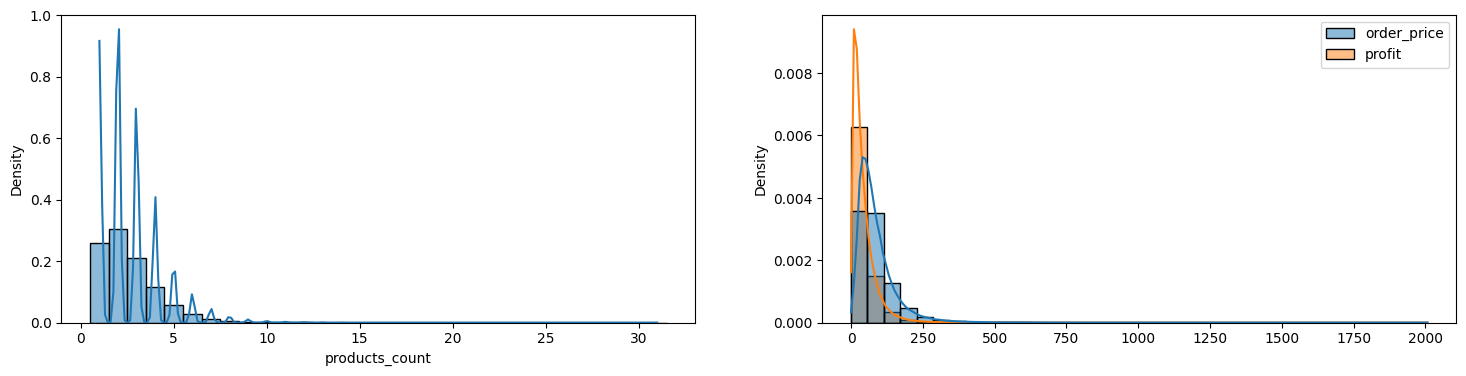

In [19]:
_, axes = plt.subplots(1, 2, figsize=(18, 4))

sns.histplot(orders["products_count"], stat='density', 
			 kde=True, bins=orders.products_count.max(), discrete=True,
             ax=axes[0])
sns.histplot(orders[["order_price","profit"]], 
             stat='density', 
			 kde=True,
             bins=35,
             ax=axes[1])

<Axes: xlabel='delivery_distance'>

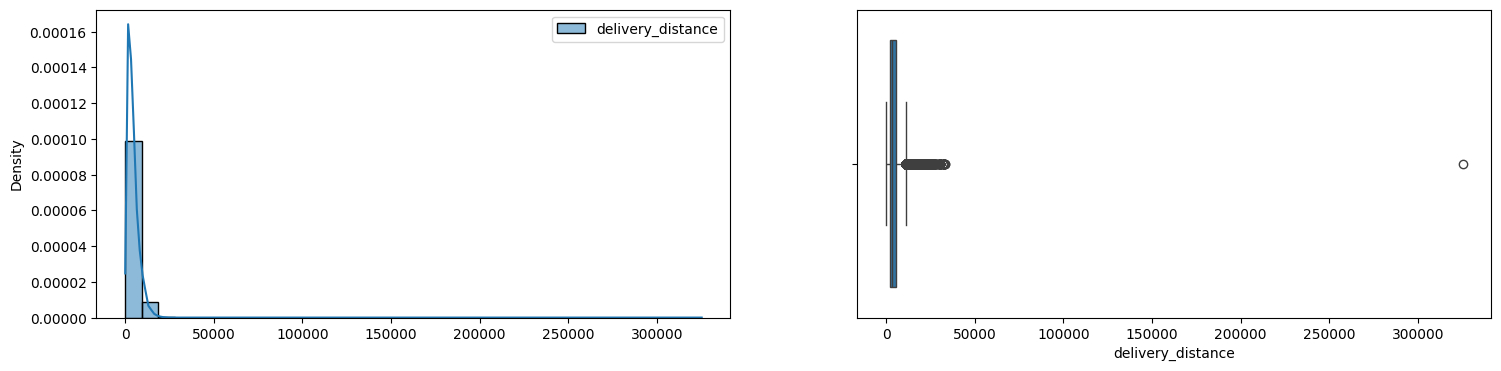

In [20]:
_, axes = plt.subplots(1, 2, figsize=(18, 4))

sns.histplot(orders[["delivery_distance"]], 
             stat='density', 
			 kde=True,
             bins=35, ax=axes[0])
sns.boxplot(x="delivery_distance", data=orders, ax=axes[1])

Here we see that `delivery_distance` has outliers

<Axes: xlabel='planned_prep_time'>

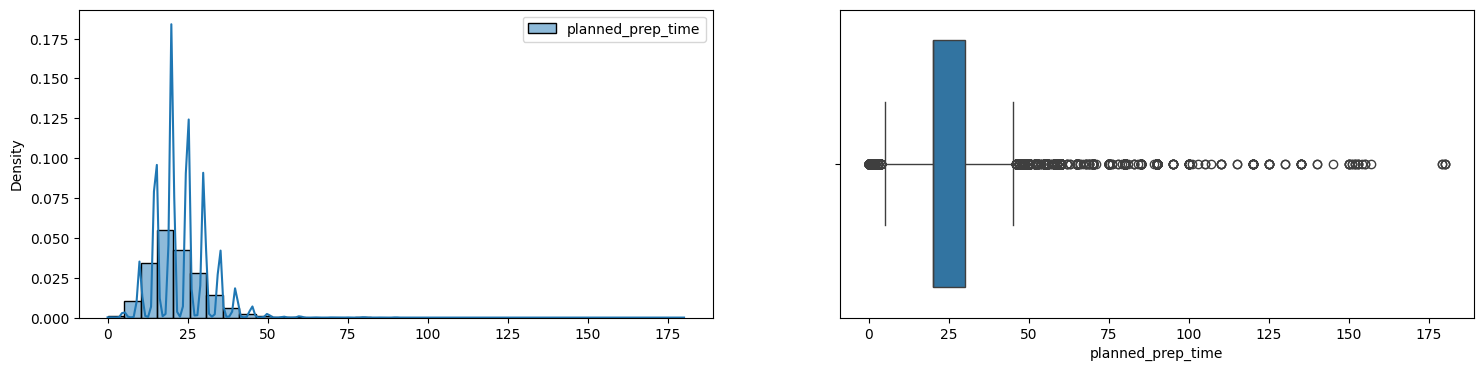

In [21]:
_, axes = plt.subplots(1, 2, figsize=(18, 4))

sns.histplot(orders[["planned_prep_time"]], 
             stat='density', 
			 kde=True,
             bins=35, ax=axes[0])
sns.boxplot(x="planned_prep_time", data=orders, ax=axes[1])

## Categorical and binary features

<Axes: title={'center': 'status_id'}, xlabel='status_id'>

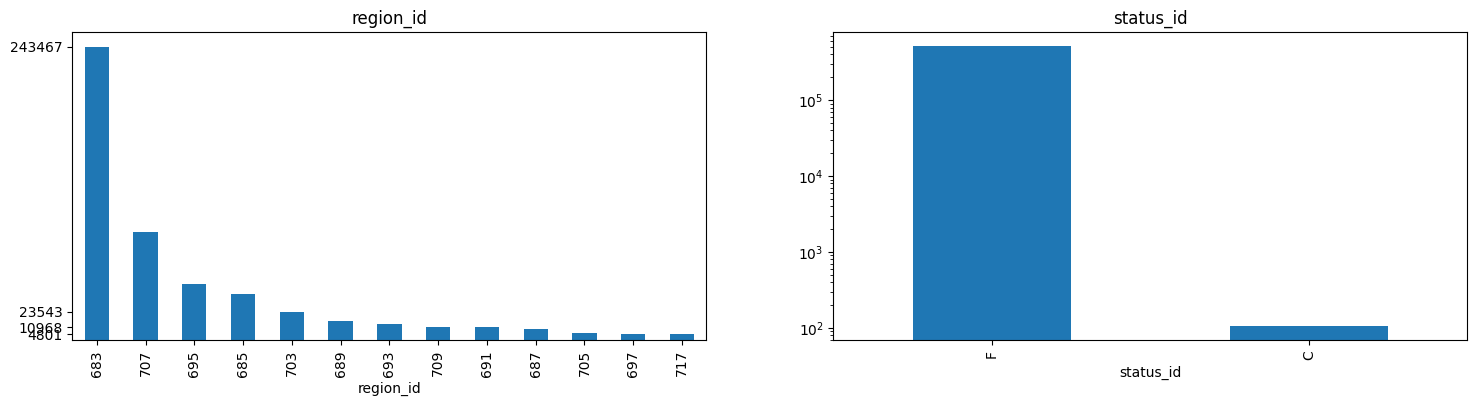

In [22]:
_, axes = plt.subplots(1,2, figsize=(18,4))
orders['region_id'].value_counts().plot(kind='bar',
                                        yticks=orders['region_id'].value_counts().values[::4],
                                        title='region_id',
                                        ax=axes[0])
orders['status_id'].value_counts().plot(kind='bar', logy=True, title='status_id', ax=axes[1])


In [23]:
orders['store_id'].value_counts()

store_id
3503     10173
5212      7433
5014      5998
4742      5185
3902      5145
         ...  
10137        1
9519         1
11783        1
11949        1
5341         1
Name: count, Length: 1419, dtype: int64

## Multi-dimentional analysis

<Axes: >

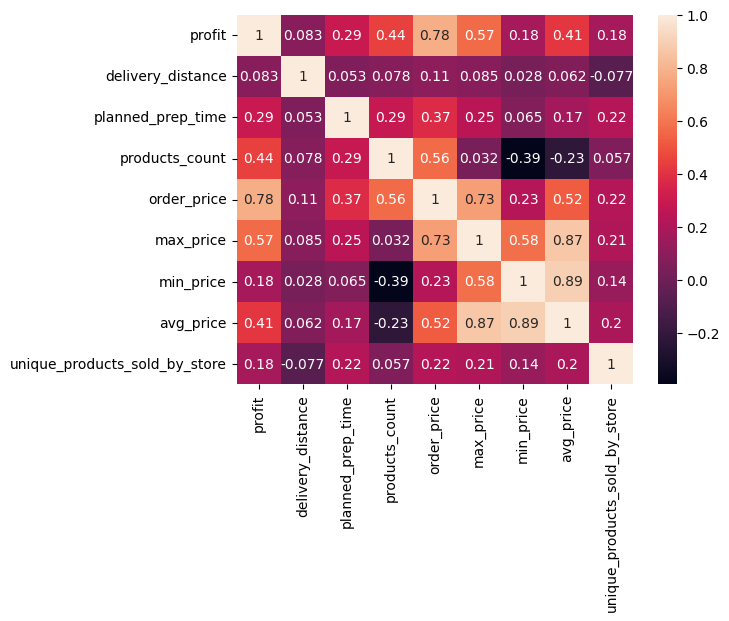

In [24]:
corr_matrix = orders.select_dtypes('number').corr()
sns.heatmap(corr_matrix, annot=True)

In [25]:
# sns.relplot(orders, 
#             kind="scatter",
#             x='order_price', y='profit', 
#             hue='actual_prep_time', size='actual_prep_time', sizes=(20, 200), hue_norm=(0, 500),
#             col="status_id")

In [26]:
# %config InlineBackend.figure_format = 'png'
# sns.pairplot(orders.select_dtypes('number'))

In [27]:
X_train, X_test = train_test_split(orders, train_size=0.9, shuffle=False)
X_train.to_csv('../content/train.csv', index=False)
X_test.to_csv('../content/test.csv', index=False)

99% quantile of "profit": 206.7
Percent of outliers from entire dataset:  0.9%
Percent of outliers from current dataset:  0.9%
Delete  4662  observations.

99% quantile of "delivery_distance": 14700.0
Percent of outliers from entire dataset:  1.0%
Percent of outliers from current dataset:  1.0%
Delete  5171  observations.

99% quantile of "planned_prep_time": 45.0
Percent of outliers from entire dataset:  0.8%
Percent of outliers from current dataset:  0.8%
Delete  4022  observations.

99% quantile of "products_count": 8.0
Percent of outliers from entire dataset:  0.6%
Percent of outliers from current dataset:  0.6%
Delete  3087  observations.

99% quantile of "order_price": 341.7
Percent of outliers from entire dataset:  1.0%
Percent of outliers from current dataset:  1.0%
Delete  5175  observations.

99% quantile of "max_price": 176.2
Percent of outliers from entire dataset:  1.0%
Percent of outliers from current dataset:  1.0%
Delete  5132  observations.

99% quantile of "min_price"

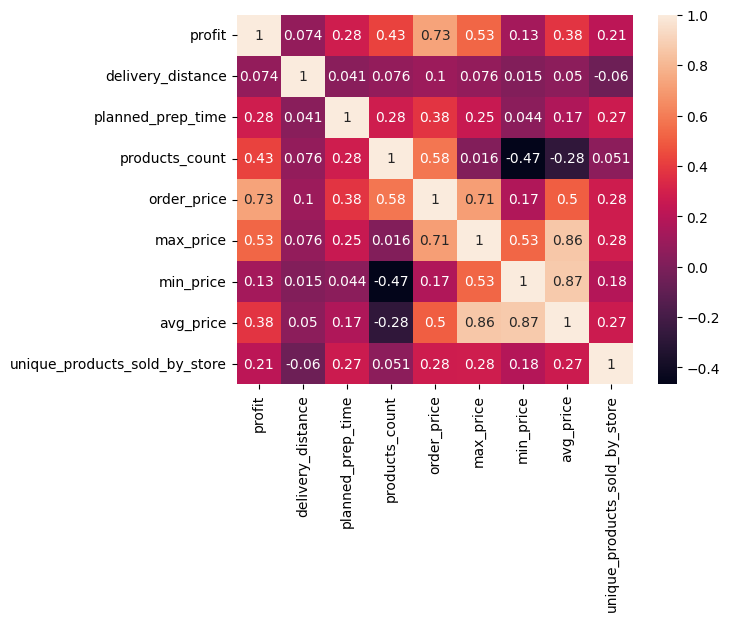

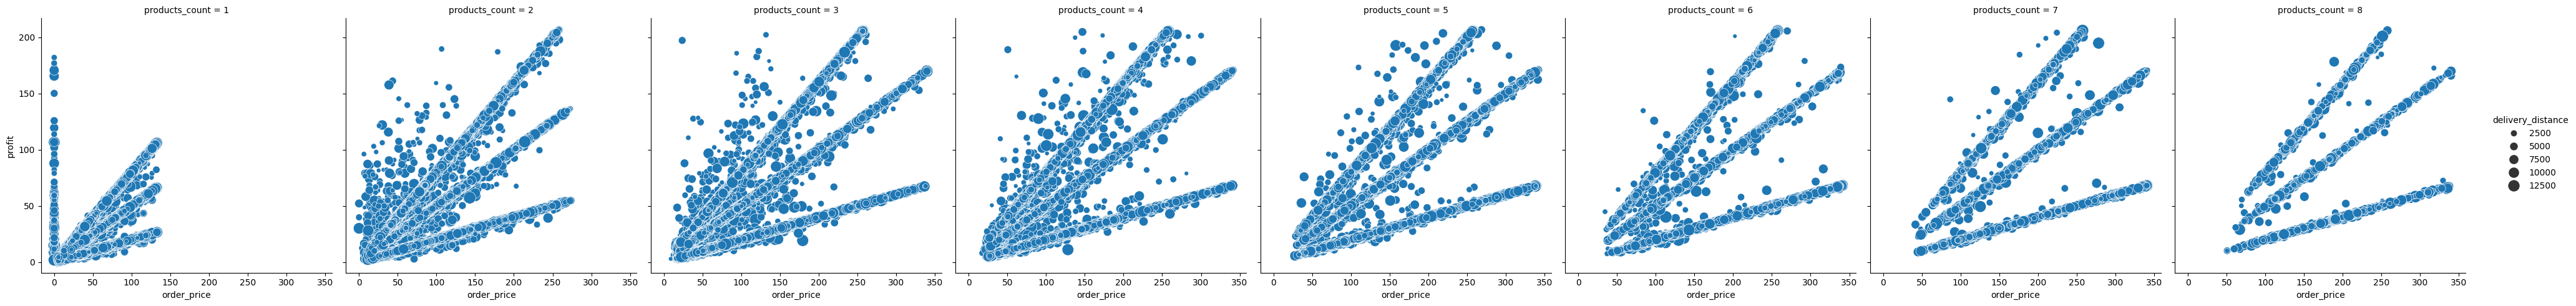

In [28]:
orders_without_outls = orders.copy()
num_dropped = 0
for feature in orders_without_outls.select_dtypes('number'):
    upper_quantile = orders[feature].quantile(q=0.99)
    print(f'99% quantile of "{feature}": {upper_quantile:.001f}')
    mask_outliers = orders[feature] > upper_quantile
    print(f"Percent of outliers from entire dataset: {mask_outliers.sum() / len(orders) * 100: 0.001f}%")
    print(f"Percent of outliers from current dataset: {mask_outliers.sum() / len(orders_without_outls) * 100 : .001f}%")
    print("Delete ", mask_outliers.sum(), " observations.\n")
    num_dropped += mask_outliers.sum()
    orders_without_outls = orders_without_outls[~mask_outliers]
print('Thus, was dropped: ', num_dropped)
print('New shape: ', orders_without_outls.shape)


corr_matrix = orders_without_outls.select_dtypes('number').corr()
sns.heatmap(corr_matrix, annot=True)

sns.relplot(orders_without_outls, 
            kind="scatter",
            x='order_price', y='profit', 
            size='delivery_distance', sizes=(20, 200),
            col="products_count")


X_train, X_test = train_test_split(orders_without_outls, train_size=0.9, shuffle=False)
X_train.to_csv('../content/train_wtht_outls.csv', index=False)
X_test.to_csv('../content/test_wtht_outls.csv', index=False)

# Preprocess the data

In [66]:
data_features = ['date_create','order_start_prepare','order_ready','order_pickup']
without_outliers = '_wtht_outls'
X_train = pd.read_csv(f'../content/train{without_outliers}.csv', parse_dates=data_features)
X_test = pd.read_csv(f'../content/test{without_outliers}.csv', parse_dates=data_features)

In [67]:
def type_casting(df):
    cat_features = ['store_id','region_id','status_id']
    float_feats = ['profit','order_price','max_price','min_price','avg_price','planned_prep_time']
    int_feats = ['delivery_distance','products_count','unique_products_sold_by_store']
    df[cat_features] = df[cat_features].astype('object')
    df[float_feats] = df[float_feats].astype('float')
    df[int_feats] = df[int_feats].astype('int')
    return df

X_train = type_casting(X_train)
X_test = type_casting(X_test)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440204 entries, 0 to 440203
Data columns (total 16 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   store_id                       440204 non-null  object        
 1   profit                         396393 non-null  float64       
 2   delivery_distance              440204 non-null  int64         
 3   date_create                    439978 non-null  datetime64[ns]
 4   order_start_prepare            396148 non-null  datetime64[ns]
 5   planned_prep_time              440203 non-null  float64       
 6   order_ready                    396478 non-null  datetime64[ns]
 7   order_pickup                   440204 non-null  datetime64[ns]
 8   region_id                      440204 non-null  object        
 9   status_id                      440204 non-null  object        
 10  products_count                 440204 non-null  int64         
 11  

In [31]:
def impute_dates_by_store(x):
    diff_date = x['order_start_prepare'] - x['date_create']
    median_diff = diff_date[diff_date > pd.to_timedelta("0 days")].median()
    x.loc[x['order_start_prepare'].isnull(), 'order_start_prepare'] = x.loc[x['order_start_prepare'].isnull(), 'date_create'] + median_diff
    x.loc[x['date_create'].isnull(), 'date_create'] = x.loc[x['date_create'].isnull(), 'order_start_prepare'] - median_diff

    diff_date = x['order_pickup'] - x['order_ready']
    median_diff = diff_date[diff_date > pd.to_timedelta("0 days")].median()
    x.loc[x['order_pickup'].isnull(), 'order_pickup'] = x.loc[x['order_pickup'].isnull(), 'order_ready'] + median_diff
    x.loc[x['order_ready'].isnull(), 'order_ready'] = x.loc[x['order_ready'].isnull(), 'order_pickup'] - median_diff
    return x

def impute_df(df):
    df.loc[:,['date_create','order_start_prepare','order_ready','order_pickup']] = df.groupby("store_id")\
            .apply(lambda x: impute_dates_by_store(x))\
            .reset_index(allow_duplicates=True)\
            .set_index('level_1')[['date_create','order_start_prepare','order_ready','order_pickup']]
    return df
    
X_train = impute_df(X_train)
X_test = impute_df(X_test)

In [32]:
def extract_target(df):
    df['actual_prep_time'] = (df['order_ready'] - df['order_start_prepare']).dt.total_seconds() / 60
    print("Nan's in actual_prep_time: ", df['actual_prep_time'].isna().sum(),
          "\nNegatives: ", (df['actual_prep_time'] < 0).sum())
    anomaly_diff_mask = (df['actual_prep_time'] < 0) | df['actual_prep_time'].isnull() 
    print(df.loc[anomaly_diff_mask].shape)
    df = df.loc[~anomaly_diff_mask]
    df.dropna(subset=['date_create','planned_prep_time'], inplace=True)
    return df.drop(columns=['order_ready','order_pickup','actual_prep_time']), df['actual_prep_time']

X_train, y_train = extract_target(X_train)
X_test, y_test = extract_target(X_test)
data_features = ['date_create','order_start_prepare']

Nan's in actual_prep_time:  30 
Negatives:  1791
(1821, 17)
Nan's in actual_prep_time:  14 
Negatives:  205
(219, 17)


In [33]:
def encode_cyclical_feat(data: pd.DataFrame, col: pd.Series, col_name: str):
    data[col_name + '_sin'] = np.sin(2 * np.pi * col/col.max())
    data[col_name + '_cos'] = np.cos(2 * np.pi * col/col.max())
    return data

def extract_date_feat(df, data_features):
    for col_name in data_features:
        df = encode_cyclical_feat(df, df[col_name].dt.month, col_name + '_month')
        df = encode_cyclical_feat(df, df[col_name].dt.day, col_name + '_day')
        df = encode_cyclical_feat(df, df[col_name].dt.weekday, col_name + '_weekday')
        df = encode_cyclical_feat(df, df[col_name].dt.hour, col_name + '_hour')
        df = encode_cyclical_feat(df, df[col_name].dt.minute, col_name + '_minute')
    df = df.drop(columns=data_features)
    return df

X_train = extract_date_feat(X_train, data_features)
X_test = extract_date_feat(X_test, data_features)
X_train.columns

Index(['store_id', 'profit', 'delivery_distance', 'planned_prep_time',
       'region_id', 'status_id', 'products_count', 'order_price', 'max_price',
       'min_price', 'avg_price', 'unique_products_sold_by_store',
       'date_create_month_sin', 'date_create_month_cos', 'date_create_day_sin',
       'date_create_day_cos', 'date_create_weekday_sin',
       'date_create_weekday_cos', 'date_create_hour_sin',
       'date_create_hour_cos', 'date_create_minute_sin',
       'date_create_minute_cos', 'order_start_prepare_month_sin',
       'order_start_prepare_month_cos', 'order_start_prepare_day_sin',
       'order_start_prepare_day_cos', 'order_start_prepare_weekday_sin',
       'order_start_prepare_weekday_cos', 'order_start_prepare_hour_sin',
       'order_start_prepare_hour_cos', 'order_start_prepare_minute_sin',
       'order_start_prepare_minute_cos'],
      dtype='object')

<Axes: ylabel='actual_prep_time'>

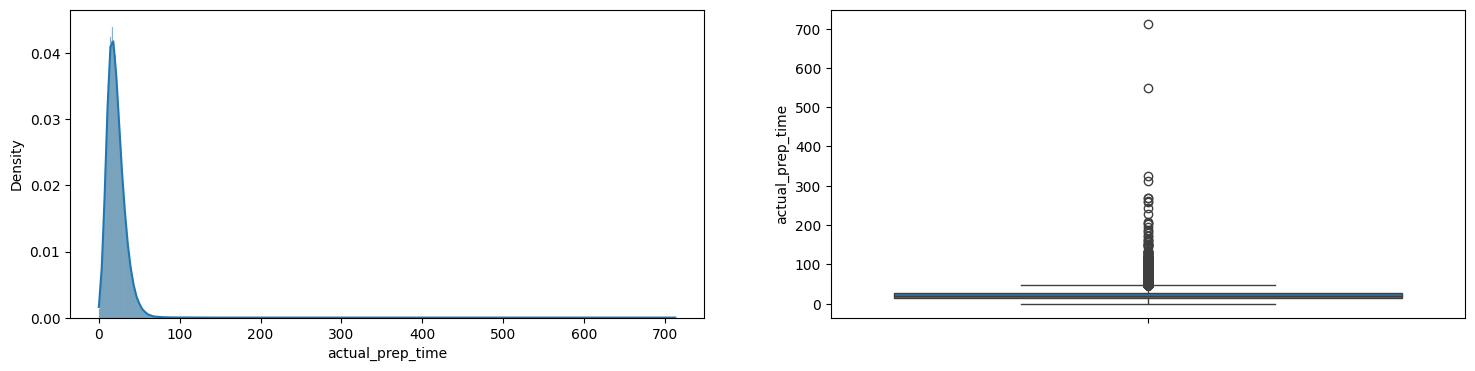

In [34]:
_, axes = plt.subplots(1, 2, figsize=(18, 4))

sns.histplot(y_train, 
             stat='density', 
			 kde=True,
            #  bins=35
            ax=axes[0]
             )
sns.boxplot(data=y_train, ax=axes[1])

In [35]:
na_columns_train = X_train.columns[X_train.isna().any()]
print(na_columns_train)
na_columns_test = X_test.columns[X_test.isna().any()]
print(na_columns_test)

Index(['profit', 'max_price', 'min_price', 'avg_price'], dtype='object')
Index(['profit', 'max_price', 'min_price', 'avg_price'], dtype='object')


In [36]:
X_train.loc[:,na_columns_train] = X_train.groupby("store_id")[na_columns_train].transform(lambda x: x.fillna(x.mode()))
X_test.loc[:,na_columns_test] = X_test.groupby("store_id")[na_columns_test].transform(lambda x: x.fillna(x.mode()))

In [37]:
# ###################################### Imputting #####################################
from sklearn.impute import SimpleImputer
col_imputing = X_test.columns[X_test.isna().any()].intersection(X_train.columns[X_train.isna().any()])
print(col_imputing)

imputer = SimpleImputer(strategy='most_frequent')
X_train[col_imputing] = pd.DataFrame(imputer.fit_transform(X_train[col_imputing]), columns=col_imputing, index=X_train.index)
X_test[col_imputing] = pd.DataFrame(imputer.transform(X_test[col_imputing]), columns=col_imputing, index=X_test.index)

Index(['profit', 'max_price', 'min_price', 'avg_price'], dtype='object')


In [38]:
###################################### Encoding #####################################
encoder = cat_boost.CatBoostEncoder(cols=cat_features, random_state=42)
X_train = encoder.fit_transform(X_train, y_train)
X_test = encoder.transform(X_test, y_test)

In [39]:
##################################### Scaling #####################################
scaler = preprocessing.MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=scaler.get_feature_names_out())
X_test = pd.DataFrame(scaler.transform(X_test), columns=scaler.get_feature_names_out())

# Regression

In [40]:
X_train.drop(inplace=True, columns=['planned_prep_time'])
X_test.drop(inplace=True, columns=['planned_prep_time'])

In [41]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

## Experiment #1

### LOGS
1. Standard, without outliers:

- Model intercept : 21.04388444324813
- Model coefficient : [ 5.52457146  0.03264817  0.85978668 -0.39949504  0.06497981  1.14025376
  1.23424433 -0.30113213 -0.15648194  0.47816519 -0.15326178  2.12079879
  5.63445821 -4.96575231 -1.16043827  0.09581642  0.37884022 -0.77774688
  6.08308759 -0.22958013  0.05987241 -2.09961301 -5.59480099  4.92868972
  1.16291024 -0.18931857 -0.45168904  0.92046575 -6.29359033  0.25323359
 -0.06398044]
- Mean Absolute Error: 6.665920038056755
- Mean Squared Error: 80.88280444459944
- Root Mean Squared Error: 8.99348677903067
- R^2: 0.2895531043061308
- [0.30691999 0.30898236 0.28459409 0.31395973 0.32878649 0.33794445
 0.30117314 0.31803191 0.31956174 0.33214268]

2. MinMax Scaler, without outliers:

- Model intercept : 1.3712186074908104
- Model coefficient : [102.66021252   0.21141436   4.36950465  -5.35861636  11.98342526
   5.64303251   8.12072922  -2.00759788  -0.93860961   3.08145893
  -0.995516     6.00321974  15.15466264 -13.89831233  -3.3377088
   0.25141261   1.01987738  -3.27090446  16.01354612  -0.6534127
   0.16816399  -5.94310041 -15.04805538  13.79461526   3.34480826
  -0.49676613  -1.21599042   3.88057743 -16.57055683   0.72082826
  -0.17967125]
- Mean Absolute Error: 6.665920038056754
- Mean Squared Error: 80.88280444459942
- Root Mean Squared Error: 8.993486779030668
- R^2: 0.289553104306131
- [0.30691999 0.30898236 0.28459409 0.31395973 0.32878649 0.33794445
 0.30117314 0.31803191 0.31956174 0.33214268]

 3. MinMax Scaler, with outliers:

- Model intercept : 1.533295500648972
- Model coefficient : [102.16912908   0.51699814  90.56447793  -5.68369878  13.4901932
  27.41855987  33.57531751 -13.06723746 -10.31361113  27.13572802
  -0.64668568   5.17596063  18.88593849 -11.18225755  -4.45147494
   0.92542868   1.31158712  -2.96720218  16.64405757  -0.71342786
   0.18598803  -5.09094565 -18.81577304  11.0865429    4.44063323
  -1.17991665  -1.49134523   3.59324426 -17.26875809   0.75936864
  -0.20168221]
- Mean Absolute Error: 6.841625042439062
- Mean Squared Error: 86.39150000730311
- Root Mean Squared Error: 9.294702792844056
- R^2: 0.30582619411149325
- [0.32596063 0.33034822 0.30366734 0.32512623 0.3385913  0.35454481
 0.31798212 0.3347442  0.33507521 0.34562636]

Model intercept : 1.3712186074908104
Model coefficient : [102.66021252   0.21141436   4.36950465  -5.35861636  11.98342526
   5.64303251   8.12072922  -2.00759788  -0.93860961   3.08145893
  -0.995516     6.00321974  15.15466264 -13.89831233  -3.3377088
   0.25141261   1.01987738  -3.27090446  16.01354612  -0.6534127
   0.16816399  -5.94310041 -15.04805538  13.79461526   3.34480826
  -0.49676613  -1.21599042   3.88057743 -16.57055683   0.72082826
  -0.17967125]
Mean Absolute Error: 6.665920038056754
Mean Squared Error: 80.88280444459942
Root Mean Squared Error: 8.993486779030668
R^2: 0.289553104306131
[0.30691999 0.30898236 0.28459409 0.31395973 0.32878649 0.33794445
 0.30117314 0.31803191 0.31956174 0.33214268]


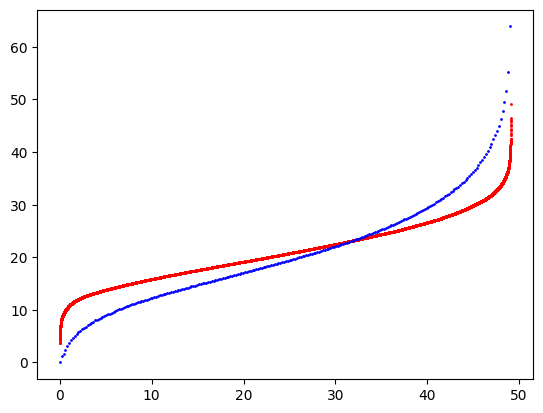

In [42]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)
print(f"Model intercept : {regressor.intercept_}")
print(f"Model coefficient : {regressor.coef_}")

y_pred = regressor.predict(X_test)
eval_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

x_axis = np.linspace(0, eval_df['Predicted'].max(), len(eval_df))
plt.scatter(x_axis, eval_df['Predicted'].sort_values(), s=1, c='r')
plt.scatter(x_axis[::200], eval_df['Actual'].sort_values()[::200], s=1, c='b')

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R^2:', metrics.r2_score(y_test, y_pred))
print(cross_val_score(regressor, X_train, y_train, cv=10))

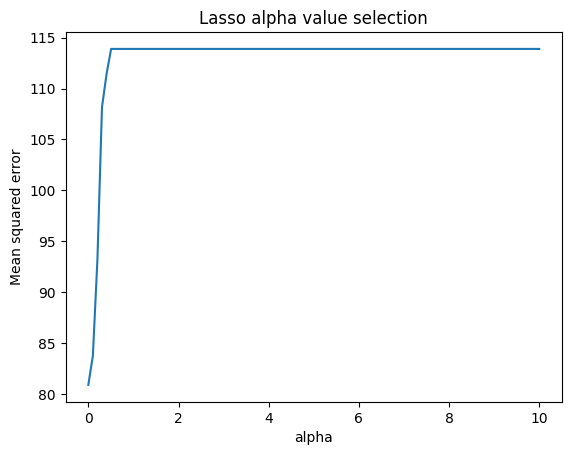

Best value of alpha: 0.0


In [43]:
from sklearn.linear_model import Lasso
alphas = np.linspace(0e-2, 10, 100)
losses = []
for alpha in alphas:
    lasso = Lasso(alpha, random_state=42)
    lasso.fit(X_train, y_train)
    losses.append(metrics.mean_squared_error(y_test, lasso.predict(X_test)))

plt.plot(alphas, losses)
plt.title("Lasso alpha value selection")
plt.xlabel("alpha")
plt.ylabel("Mean squared error")
plt.show()

best_alpha = alphas[np.argmin(losses)]
print("Best value of alpha:", best_alpha)

In [44]:
alpha = 0.01
lasso = Lasso(alpha, random_state=42)
lasso.fit(X_train, y_train)

y_pred = lasso.predict(X_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R^2:', metrics.r2_score(y_test, y_pred))

importance_features = abs(pd.Series(lasso.coef_, lasso.feature_names_in_)).sort_values()
importance_features = importance_features[importance_features > 0.1]
importance_features

Mean Absolute Error: 6.66455897272515
Mean Squared Error: 80.83037520930846
Root Mean Squared Error: 8.990571461776412
R^2: 0.2900136247803139


date_create_weekday_sin          0.177239
order_start_prepare_hour_cos     0.432551
order_start_prepare_hour_sin     0.545892
region_id                        2.184669
delivery_distance                4.079795
products_count                   5.170006
order_price                      8.006898
store_id                        97.224909
dtype: float64

## Experiment #2

In [45]:
X_train_reg = X_train[importance_features.index]
X_test_reg = X_test[importance_features.index]

Model intercept : 2.3784699186880403
date_create_weekday_sin           0.241093
order_start_prepare_hour_cos      0.516421
order_start_prepare_hour_sin      0.747510
delivery_distance                 4.382110
products_count                    5.283594
region_id                         5.328702
order_price                       8.264285
store_id                        101.878183
dtype: float64 


Mean Absolute Error: 6.667226083790555
Mean Squared Error: 80.91069464079663
Root Mean Squared Error: 8.995037222868877
R^2: 0.2893081263600191


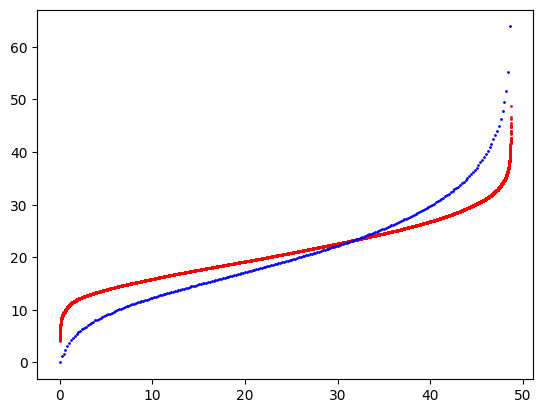

In [46]:
from sklearn.linear_model import LinearRegression

regressor = LinearRegression()
regressor.fit(X_train_reg, y_train)
print(f"Model intercept : {regressor.intercept_}")
print(abs(pd.Series(regressor.coef_, regressor.feature_names_in_)).sort_values(), '\n\n')

y_pred = regressor.predict(X_test_reg)
eval_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

x_axis = np.linspace(0, eval_df['Predicted'].max(), len(eval_df))
plt.scatter(x_axis, eval_df['Predicted'].sort_values(), s=1, c='r')
plt.scatter(x_axis[::200], eval_df['Actual'].sort_values()[::200], s=1, c='b')

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R^2:', metrics.r2_score(y_test, y_pred))

## PCA

In [47]:
from sklearn.decomposition import PCA
###################################### PCA ######################################

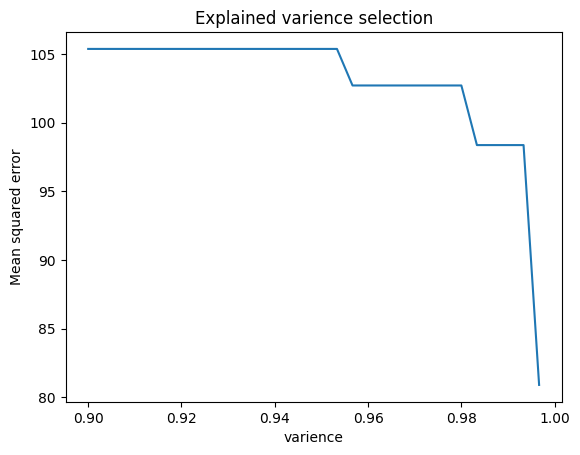

Best value of explained_variance: 0.9966666666666667


In [48]:
losses = []
explained_variances = np.linspace(0.9, 1, 30, endpoint=False)
for i in explained_variances:
    pca = PCA(n_components=i, random_state=42)
    X_train_pca = pca.fit_transform(X_train_reg)
    X_test_pca = pca.transform(X_test_reg)

    regressor = LinearRegression()
    regressor.fit(X_train_pca, y_train)
    
    losses.append(metrics.mean_squared_error(y_test, regressor.predict(X_test_pca)))
    

plt.plot(explained_variances, losses)
plt.title("Explained varience selection")
plt.xlabel("varience")
plt.ylabel("Mean squared error")
plt.show()
best_variance = explained_variances[np.argmin(losses)]
print("Best value of explained_variance:", best_variance)

Model intercept : 21.043884443248132
Model coefs:  [ 0.45015453 -0.40488062 -6.30891485 11.96399217  2.00140958 14.81997867
 28.27218341 96.52771985] 


Mean Absolute Error: 6.667226083790554
Mean Squared Error: 80.91069464079663
Root Mean Squared Error: 8.995037222868877
R^2: 0.2893081263600191
Cross-validation scores: [0.30653596 0.29836789 0.33350055 0.30915929 0.32458258]


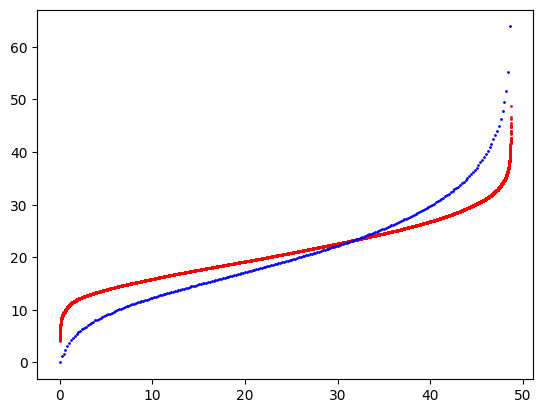

In [49]:
explained_variance = best_variance

pca = PCA(n_components=explained_variance)  
X_train_pca = pca.fit_transform(X_train_reg)
X_test_pca = pca.transform(X_test_reg)

regressor = LinearRegression()
regressor.fit(X_train_pca, y_train)
print(f"Model intercept : {regressor.intercept_}")
print("Model coefs: ", regressor.coef_, '\n\n')
y_pred = regressor.predict(X_test_pca)

eval_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
x_axis = np.linspace(0, eval_df['Predicted'].max(), len(eval_df))
plt.scatter(x_axis, eval_df['Predicted'].sort_values(), s=1, c='r')
plt.scatter(x_axis[::200], eval_df['Actual'].sort_values()[::200], s=1, c='b')

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R^2:', metrics.r2_score(y_test, y_pred))
scores = cross_val_score(regressor, X_train_pca, y_train, cv=5)
print("Cross-validation scores:", scores)

## Ridge

In [50]:
X_train_reg.columns

Index(['date_create_weekday_sin', 'order_start_prepare_hour_cos',
       'order_start_prepare_hour_sin', 'region_id', 'delivery_distance',
       'products_count', 'order_price', 'store_id'],
      dtype='object')

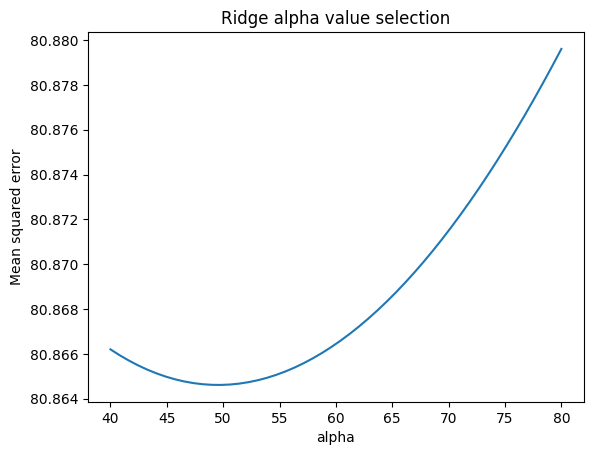

Best value of alpha: 49.79591836734694
Mean Absolute Error: 6.670669225106229
Mean Squared Error: 80.86461432809615
Root Mean Squared Error: 8.992475428273139
R^2: 0.2897128800692341


date_create_weekday_sin          0.244381
order_start_prepare_hour_cos     0.521405
order_start_prepare_hour_sin     0.737342
region_id                        4.242607
delivery_distance                4.374479
products_count                   5.244160
order_price                      8.501083
store_id                        97.423750
dtype: float64

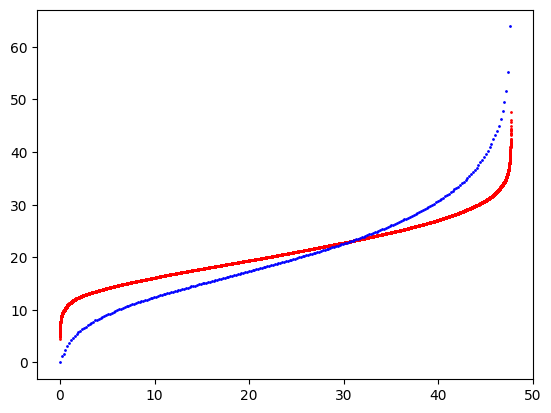

In [51]:
from sklearn.linear_model import Ridge
alphas = np.linspace(40, 80, 50)
losses = []
for alpha in alphas:
    ridge = Ridge(alpha, random_state=42)
    ridge.fit(X_train_reg, y_train)
    losses.append(metrics.mean_squared_error(y_test, ridge.predict(X_test_reg)))
   
    
plt.plot(alphas, losses)
plt.title("Ridge alpha value selection")
plt.xlabel("alpha")
plt.ylabel("Mean squared error")
plt.show()

best_alpha = alphas[np.argmin(losses)]
print("Best value of alpha:", best_alpha)

alpha = best_alpha
ridge = Ridge(alpha, random_state=42)
ridge.fit(X_train_reg, y_train)
y_pred = ridge.predict(X_test_reg)


print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R^2:', metrics.r2_score(y_test, y_pred))

eval_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
x_axis = np.linspace(0, eval_df['Predicted'].max(), len(eval_df))
plt.scatter(x_axis, eval_df['Predicted'].sort_values(), s=1, c='r')
plt.scatter(x_axis[::200], eval_df['Actual'].sort_values()[::200], s=1, c='b')


abs(pd.Series(ridge.coef_, ridge.feature_names_in_)).sort_values()

## Polynomial

In [52]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA

features = ['unique_products_sold_by_store', 'order_start_prepare_hour_sin',
       'order_start_prepare_hour_cos', 'region_id', 'delivery_distance',
       'products_count', 'order_price', 'store_id']

- Principal components:  7
- Polynomial degree:  3
- Mean Absolute Error: 6.629615770644926
- Mean Squared Error: 80.39140632977117
- Root Mean Squared Error: 8.966125491524819
- R^2: 0.2938693773091111

Principal components:  7
Polynomial degree:  3
Mean Absolute Error: 6.8968748486291656
Mean Squared Error: 85.78588164514822
Root Mean Squared Error: 9.262066812820356
R^2: 0.24648615082452652 




,Actual,Predicted
0,6.550000,19.451691
1,15.633333,22.12599
2,14.000000,19.458492
3,46.400000,21.516914
4,15.450000,33.740403
...,...,...
48687,16.716667,13.128543
48688,16.333333,13.453995
48689,14.900000,15.049511
48690,10.516667,7.983973


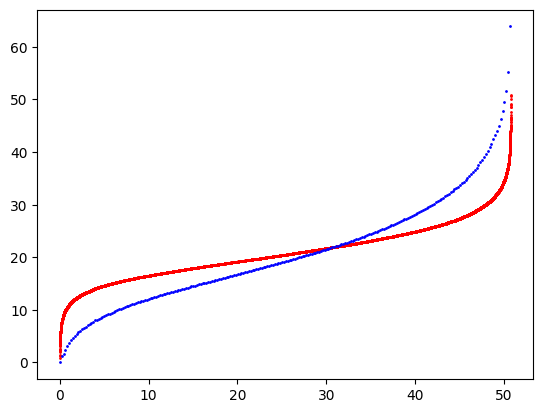

In [53]:
degrees = [3]
n_components = [7]
for i in degrees:
    for components in n_components:
        pca = PCA(n_components=components, random_state=42)  # Сохраняем 95% объясненной дисперсии
        X_train_poly = pca.fit_transform(X_train_reg)
        X_test_poly = pca.transform(X_test_reg)


        polynomial_features = PolynomialFeatures(degree=i)
        linear_regression = LinearRegression()
        pipeline = Pipeline([("polynomial_features", polynomial_features),
                            ("linear_regression", linear_regression)])
        pipeline.fit(X_train_poly, y_train.to_frame())

        y_pred = pipeline.predict(X_test_poly)
        print("Principal components: ", components)
        print("Polynomial degree: ", i)
        print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
        print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
        print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
        print('R^2:', metrics.r2_score(y_test, y_pred),'\n\n')

eval_df = pd.DataFrame({'Actual': y_test.reset_index(drop=True), 'Predicted': pd.Series(y_pred.tolist()).explode()})
x_axis = np.linspace(0, eval_df['Predicted'].max(), len(eval_df))
plt.scatter(x_axis, eval_df['Predicted'].sort_values(), s=1, c='r')
plt.scatter(x_axis[::200], eval_df['Actual'].sort_values()[::200], s=1, c='b')
eval_df

## Support vector regression

In [54]:
from sklearn.svm import SVR

In [55]:
pca = PCA(n_components=7, random_state=42)
X_train_svr = pca.fit_transform(X_train_reg)
X_test_svr = pca.transform(X_test_reg)

number of support vectors for each class:  [2000] 


Mean Absolute Error: 11.599261626645948
Mean Squared Error: 209.5975466205103
Root Mean Squared Error: 14.477484126066596
R^2: -0.8410331758907645 




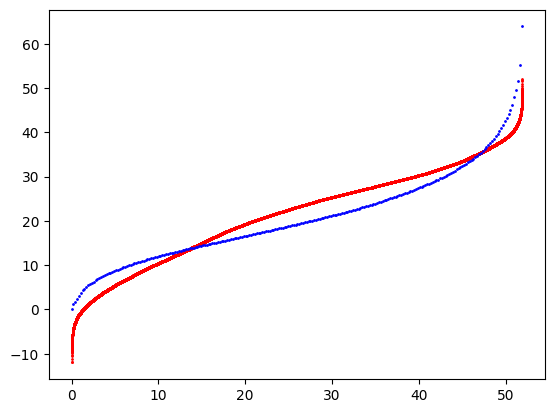

In [56]:
svr = SVR(kernel='rbf',C=40, gamma=1, max_iter=1000)
svr.fit(X_train_svr, y_train)

y_pred = svr.predict(X_test_svr)
# print("Support vectors: ", svr.support_vectors_) # get support vectors
# print("indices of support vectors: ", svr.support_) # get indices of support vectors
print("number of support vectors for each class: ", svr.n_support_,'\n\n') # get number of support vectors for each class


print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R^2:', metrics.r2_score(y_test, y_pred),'\n\n')

eval_df = pd.DataFrame({'Actual': y_test.reset_index(drop=True), 'Predicted': pd.Series(y_pred.tolist()).explode()})
x_axis = np.linspace(0, eval_df['Predicted'].max(), len(eval_df))
plt.scatter(x_axis, eval_df['Predicted'].sort_values(), s=1, c='r')
plt.scatter(x_axis[::200], eval_df['Actual'].sort_values()[::200], s=1, c='b')

## Neural Network

In [57]:
import torch
from torch import nn, optim

In [58]:
X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor = (torch.tensor(batch.values, dtype=torch.float32, device='cuda') 
                                                                for batch 
                                                                in (X_train_reg, X_test_reg, y_train, y_test))

type(X_train_tensor), X_train_tensor.shape, type(y_train_tensor), y_train_tensor.shape

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [264]:
model = nn.Sequential(nn.LazyLinear(256), nn.ReLU(), nn.LazyLinear(64), nn.ReLU(), nn.LazyLinear(16), nn.LazyLinear(1), nn.ReLU(), nn.Dropout(p=0.5))
model = model.to('cuda')


mean_train_losses = []
mean_valid_losses = []
valid_acc_list = []

In [293]:
epochs = 1000
lr = 0.0001

loss_fn = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0.00001)


for epoch in range(epochs):
    model.train()
    
    train_losses = []
    valid_losses = []
    
    optimizer.zero_grad()
    
    outputs = model(X_train_tensor).squeeze()
    loss = loss_fn(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    
    train_losses.append(loss.item())
            
    mean_train_losses.append(np.mean(train_losses))
   

    print('epoch : {}, train loss : {:.4f}'\
         .format(epoch+1, np.mean(train_losses)))


epoch : 1, train loss : 13.8291
epoch : 2, train loss : 13.8091
epoch : 3, train loss : 13.8058
epoch : 4, train loss : 13.8009
epoch : 5, train loss : 13.8104
epoch : 6, train loss : 13.7906
epoch : 7, train loss : 13.7975
epoch : 8, train loss : 13.7906
epoch : 9, train loss : 13.8276
epoch : 10, train loss : 13.8132
epoch : 11, train loss : 13.8140
epoch : 12, train loss : 13.8049
epoch : 13, train loss : 13.8104
epoch : 14, train loss : 13.8159
epoch : 15, train loss : 13.8273
epoch : 16, train loss : 13.7992
epoch : 17, train loss : 13.7978
epoch : 18, train loss : 13.8050
epoch : 19, train loss : 13.8004
epoch : 20, train loss : 13.8025
epoch : 21, train loss : 13.8066
epoch : 22, train loss : 13.8049
epoch : 23, train loss : 13.7872
epoch : 24, train loss : 13.7967
epoch : 25, train loss : 13.8398
epoch : 26, train loss : 13.8275
epoch : 27, train loss : 13.7942
epoch : 28, train loss : 13.8042
epoch : 29, train loss : 13.8306
epoch : 30, train loss : 13.8240
epoch : 31, train l

Mean Absolute Error: 11.329302149121212
Mean Squared Error: 206.2743601592091
Root Mean Squared Error: 14.362254703186721
R^2: -0.8118434424059364 




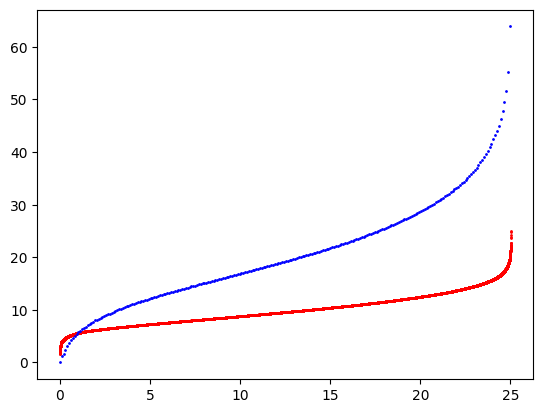

In [295]:
model = model.eval()

y_pred = model(X_test_tensor)
y_pred = y_pred.to('cpu').detach().numpy()

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R^2:', metrics.r2_score(y_test, y_pred),'\n\n')

eval_df = pd.DataFrame({'Actual': y_test.reset_index(drop=True), 'Predicted': pd.Series(y_pred.tolist()).explode()})
x_axis = np.linspace(0, eval_df['Predicted'].max(), len(eval_df))
plt.scatter(x_axis, eval_df['Predicted'].sort_values(), s=1, c='r')
plt.scatter(x_axis[::200], eval_df['Actual'].sort_values()[::200], s=1, c='b')

# Classification

## EDA for classification

In [267]:
df['on_time'] = np.where(abs(df['planned_prep_time'] - df['actual_prep_time']) <= 5, 1, 0)

KeyError: 'actual_prep_time'

In [ ]:
pie_data = orders.value_counts('on_time')
plt.pie(pie_data, labels=pie_data.index.map({0:'Late', 1:"On time"}), autopct='%0.01f%%')

In [ ]:
sns.catplot(
    x="on_time",
    y="products",
    col="region_id",
    data=orders,
    kind="box",
    col_wrap=4,
    height=3,
    aspect=0.8,
);

In [83]:
df = pd.read_csv('../content/orders_with_target.csv')
df.columns

In [67]:
df.info()

In [61]:
# experiment #1
feature_selected = ['store_id', 'products', 'order_price', 'profit', 'delivery_distance',
       'region_id', 'date_create_month_sin',
       'date_create_month_cos', 'date_create_day_sin', 'date_create_day_cos',
       'date_create_weekday_sin', 'date_create_weekday_cos',
       'date_create_hour_sin', 'date_create_hour_cos',
       'date_create_minute_sin', 'date_create_minute_cos',
       'order_start_prepare_month_sin', 'order_start_prepare_month_cos',
       'order_start_prepare_day_sin', 'order_start_prepare_day_cos',
       'order_start_prepare_weekday_sin', 'order_start_prepare_weekday_cos',
       'order_start_prepare_hour_sin', 'order_start_prepare_hour_cos',
       'order_start_prepare_minute_sin', 'order_start_prepare_minute_cos', 'on_time']
df = df[feature_selected]

In [85]:
# experiment #2
feature_selected = ['store_id', 'products', 'order_price', 'profit', 'delivery_distance',
       'region_id', 
       'date_create_hour_cos',
       'order_start_prepare_hour_cos',
       'on_time']
df = df[feature_selected]

In [86]:
target = 'on_time'
cat_features = ['store_id','region_id']
numeric_features = df.columns.difference(cat_features + [target])
df[cat_features] = df[cat_features].astype('object') 

In [88]:
# Experiment #2
from sklearn.linear_model import LogisticRegression

# fit Logistic Regression
clf = LogisticRegression(random_state=42).fit(X_train, y_train)
y_test_pred = clf.predict(X_test)

# calculate metrics
print('Testing accuracy = {}'.format(metrics.accuracy_score(y_test, y_test_pred)))
print('Testing precision = {}'.format(metrics.precision_score(y_test, y_test_pred)))
print('Testing recall = {}'.format(metrics.recall_score(y_test, y_test_pred)))

# Logistic Regression Coefficients
print("----Logistic Regression Coefficients----")
print(*[a for a in zip(list(X_train.columns), clf.coef_[0])], sep='\n')

In [89]:
# TODO: calculate metrics for each threshold above and plot the result as below.
# thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
thresholds = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,.7,.75,.8,.85,.9,.95,.99]
pred_proba = clf.predict_proba(X_test)

results = [[],[],[]]
for i in thresholds:
    y_test_pred_thr = np.where(pred_proba[:, 1] > i, 1, 0)
    results[0].append(metrics.accuracy_score(y_test, y_test_pred_thr)) # accuracy 
    results[1].append(metrics.precision_score(y_test, y_test_pred_thr)) # precision
    results[2].append(metrics.recall_score(y_test, y_test_pred_thr)) # recall
    
plt.plot(thresholds, results[0], label = 'accuracy')   
plt.plot(thresholds, results[1], label = 'precision')   
plt.plot(thresholds, results[2], label = 'recall')
plt.title('Threshold Selection')
plt.xlabel('threshold')
plt.ylabel('score')
plt.legend()
plt.grid()

In [91]:
# Select the optimal prediction threshold
optimal_thresholds = 0.4

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


pred_proba = clf.predict_proba(X_test)
y_pred = np.where(pred_proba[:, 1] > optimal_thresholds, 1, 0)

cm = confusion_matrix(y_test, y_pred, labels=clf.classes_, 
                    #   normalize='true'
                      )
ConfusionMatrixDisplay(cm, display_labels=clf.classes_).plot()

# calculate metrics
print('Testing accuracy = {}'.format(metrics.accuracy_score(y_test, y_pred)))
print('Testing precision = {}'.format(metrics.precision_score(y_test, y_pred)))
print('Testing recall = {}'.format(metrics.recall_score(y_test, y_pred)))
print('Testing f1_score = {}'.format(metrics.f1_score(y_test, y_pred)))